In [13]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from datetime import datetime
import gc
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

In [14]:
train = pd.read_csv('train.csv', encoding = "ISO-8859-1")
test_x = pd.read_csv('test.csv', encoding = "ISO-8859-1")
test_y = pd.read_csv('test_salaries.csv') 

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Columns: 154 entries, Salary to GS/G
dtypes: float64(73), int64(71), object(10)
memory usage: 736.4+ KB


In [17]:
obj_cols = train.select_dtypes('object')
obj_cols.head()

,Born,City,Pr/St,Cntry,Nat,Hand,Last Name,First Name,Position,Team
0,97-01-30,Sainte-Marie,QC,CAN,CAN,L,Chabot,Thomas,D,OTT
1,93-12-21,Ottawa,ON,CAN,CAN,R,Ceci,Cody,D,OTT
2,88-04-16,St. Paul,MN,USA,USA,R,Okposo,Kyle,RW,BUF
3,92-01-07,Ottawa,ON,CAN,CAN,R,Gudbranson,Erik,D,VAN
4,94-03-29,Toronto,ON,CAN,CAN,R,Wilson,Tom,RW,WSH


In [18]:
obj_cols = train.select_dtypes('object')
obj_cols.head()

,Born,City,Pr/St,Cntry,Nat,Hand,Last Name,First Name,Position,Team
0,97-01-30,Sainte-Marie,QC,CAN,CAN,L,Chabot,Thomas,D,OTT
1,93-12-21,Ottawa,ON,CAN,CAN,R,Ceci,Cody,D,OTT
2,88-04-16,St. Paul,MN,USA,USA,R,Okposo,Kyle,RW,BUF
3,92-01-07,Ottawa,ON,CAN,CAN,R,Gudbranson,Erik,D,VAN
4,94-03-29,Toronto,ON,CAN,CAN,R,Wilson,Tom,RW,WSH


In [19]:
train.Born.head()

0    97-01-30
1    93-12-21
2    88-04-16
3    92-01-07
4    94-03-29
Name: Born, dtype: object

In [23]:
for c in obj_cols.columns:
    print('Obj Col: ', c, '   Number of Unqiue Values ->', len(obj_cols[c].value_counts()))

Obj Col:  Born    Number of Unqiue Values -> 576
Obj Col:  City    Number of Unqiue Values -> 373
Obj Col:  Pr/St    Number of Unqiue Values -> 37
Obj Col:  Cntry    Number of Unqiue Values -> 18
Obj Col:  Nat    Number of Unqiue Values -> 16
Obj Col:  Hand    Number of Unqiue Values -> 2
Obj Col:  Last Name    Number of Unqiue Values -> 573
Obj Col:  First Name    Number of Unqiue Values -> 308
Obj Col:  Position    Number of Unqiue Values -> 18
Obj Col:  Team    Number of Unqiue Values -> 68


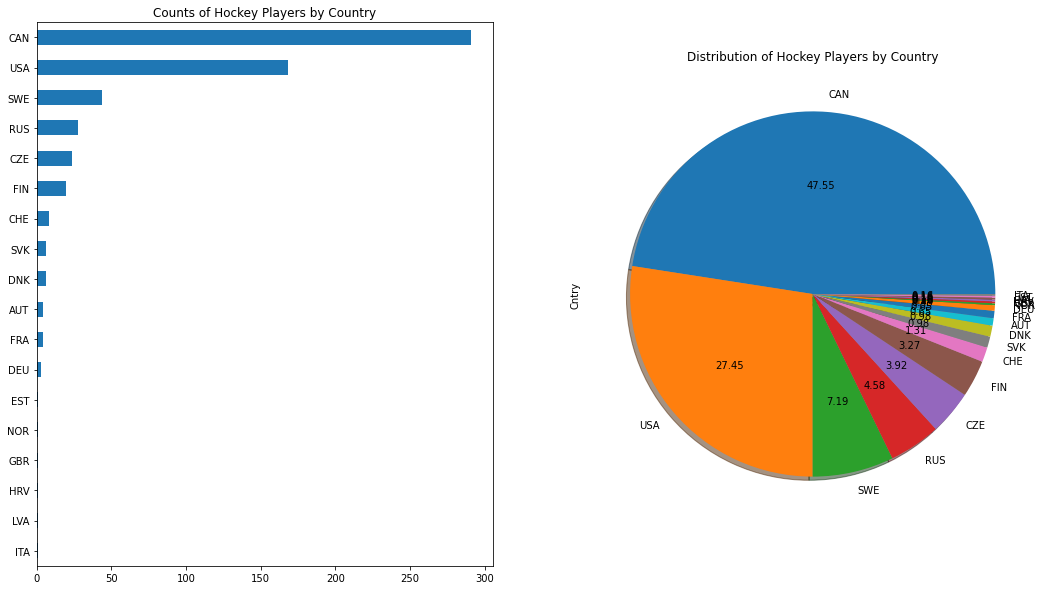

In [24]:
fig, ax=plt.subplots(1,2,figsize=(18,10))
obj_cols['Cntry'].value_counts().sort_values().plot(kind='barh',ax=ax[0]) 
ax[0].set_title("Counts of Hockey Players by Country");
obj_cols['Cntry'].value_counts().plot(kind='pie', autopct='%.2f', shadow=True,ax=ax[1]);
ax[1].set_title("Distribution of Hockey Players by Country");

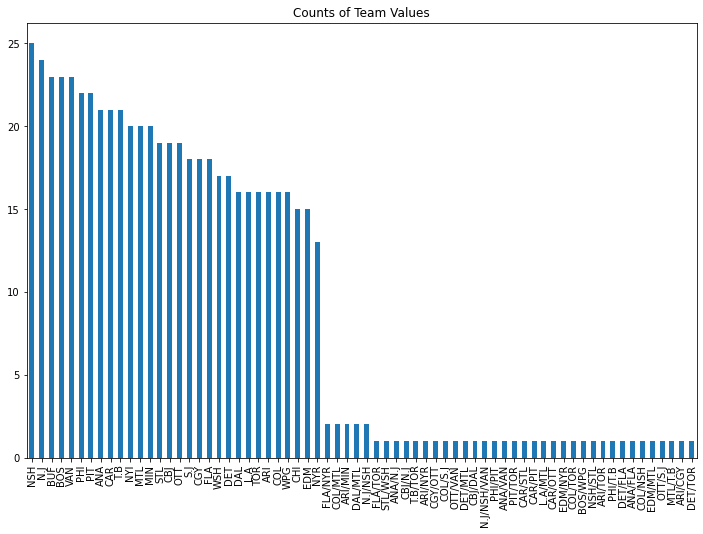

In [25]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
obj_cols['Team'].value_counts().plot(kind='bar',ax=ax);
plt.title('Counts of Team Values');

In [27]:
sal_gtmil = train[train.Salary >= 1e7]

In [28]:
sal_gtmil.head(10)

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
103,13800000,88-11-19,Buffalo,NY,USA,USA,71,177,2007.0,1.0,...,91.0,8.7,2.1,10.8,3057.71,75,4.8,114.0,89.2,1.09
145,10900000,87-08-07,Cole Harbour,NS,CAN,CAN,71,200,2005.0,1.0,...,110.0,10.5,1.7,12.3,2880.93,131,9.9,125.4,94.6,1.26
208,11000000,89-05-13,Toronto,ON,CAN,CAN,72,210,2007.0,2.0,...,99.0,3.6,2.4,6.1,2338.29,228,6.8,110.1,52.8,0.80
226,10000000,89-08-15,Kladno,NaN,CZE,CZE,74,214,2007.0,1.0,...,112.0,4.6,1.0,5.6,3161.36,110,4.2,120.7,60.4,0.74
260,10000000,85-09-17,Moscow,NaN,RUS,RUS,75,239,2004.0,1.0,...,72.0,7.0,1.7,8.7,3150.92,295,9.8,122.1,75.6,0.92
496,13800000,88-04-29,Winnipeg,MB,CAN,CAN,74,201,2006.0,1.0,...,78.0,4.7,1.6,6.3,2866.62,111,5.3,116.8,62.4,0.87
542,12000000,85-08-14,Sicamous,BC,CAN,CAN,76,232,2003.0,2.0,...,115.0,4.1,6.0,10.1,2759.46,335,7.9,110.3,53.9,0.69


In [29]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
def data_clean(x):
    ## Were going to change Born to date time
    x['Born'] = pd.to_datetime(x.Born, yearfirst=True)
    x['dowBorn'] = x.Born.dt.dayofweek
    x["doyBorn"] = x.Born.dt.dayofyear
    x["monBorn"] = x.Born.dt.month
    x['yrBorn'] = x.Born.dt.year
    ## Drop Pr/St due to NaNs from other countries and First Name
    x.drop(['Pr/St','First Name'], axis=1, inplace=True)
    ocols = ['City', 'Cntry', 'Nat', 'Last Name', 'Position', 'Team']
    for oc in ocols:
        temp = pd.get_dummies(x[oc])
        x = x.join(temp, rsuffix=str('_'+oc))
    x['Hand'] = pd.factorize(x.Hand)[0]
    x.drop(ocols, axis=1, inplace=True)
    x.drop(['Born'],axis=1,inplace=True)
    return x

In [31]:
try:
    del train, x0, xc, test
except:
    pass

In [34]:
train = pd.read_csv('train.csv', encoding = "ISO-8859-1")

In [35]:
train.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [37]:
test_x = pd.read_csv('test.csv', encoding = "ISO-8859-1")
##test_y = pd.read_csv('test_salaries.csv') 

In [39]:
test_x.head()

,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,Ovrl,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,88-11-05,Ithaca,NY,USA,USA,72,216,2003.0,1.0,13.0,...,65,1.9,1.8,3.7,3418.06,243,19.5,110.4,47.3,0.59
1,00-02-29,Prague,NaN,CZE,CZE,72,195,2014.0,1.0,13.0,...,10,0.3,0.3,0.6,826.49,15,10.0,118.6,8.9,0.42
2,92-04-24,St. Louis,MO,USA,USA,75,227,2007.0,6.0,161.0,...,86,3.9,2.0,6.0,3155.13,316,8.9,115.0,52.5,0.65
3,99-07-05,Piikkio,NaN,FIN,FIN,72,182,2013.0,2.0,55.0,...,40,2.3,1.1,3.4,3044.03,105,24.3,111.9,38.1,0.52
4,96-10-27,Niagara Falls,NY,USA,USA,72,196,2011.0,2.0,36.0,...,25,0.8,1.1,1.9,1217.17,67,4.8,105.4,15.9,0.51


In [41]:
full = train.merge(test_x, how='outer')
#print(train.shape, test.shape, full.shape)

In [42]:
print(train.shape, test_x.shape, full.shape)

(612, 154) (262, 153) (874, 154)


In [43]:
y = np.log(full.Salary.dropna())
full0 = full.drop(['Salary'],axis=1)

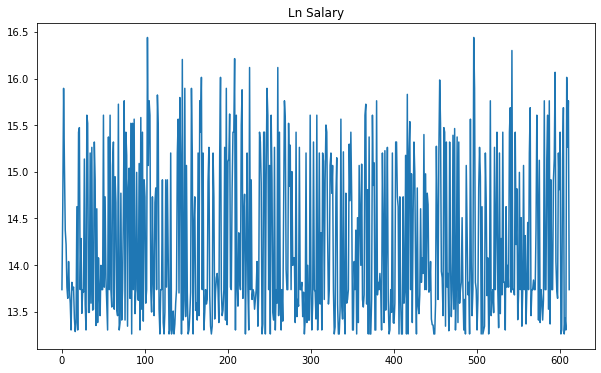

In [44]:
fig, ax=plt.subplots(1,1,figsize=(10,6))
y.plot(ax=ax);
plt.title("Ln Salary");

In [45]:
obj_cols.columns

Index(['Born', 'City', 'Pr/St', 'Cntry', 'Nat', 'Hand', 'Last Name',
       'First Name', 'Position', 'Team'],
      dtype='object')

In [46]:
full_c = data_clean(full0)

In [47]:
print(full0.shape, full_c.shape)

(874, 155) (874, 1573)


In [48]:
full_c.head()

,Ht,Wt,DftYr,DftRd,Ovrl,Hand,GP,G,A,A1,...,S.J,S.J/VAN,STL,STL/WSH,T.B,T.B/TOR,TOR,VAN,WPG,WSH
0,74,190,2015.0,1.0,18.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,74,207,2012.0,1.0,15.0,1,79,2,15,6,...,0,0,0,0,0,0,0,0,0,0
2,72,218,2006.0,1.0,7.0,1,65,19,26,13,...,0,0,0,0,0,0,0,0,0,0
3,77,220,2010.0,1.0,3.0,1,30,1,5,5,...,0,0,0,0,0,0,0,1,0,0
4,76,217,2012.0,1.0,16.0,1,82,7,12,4,...,0,0,0,0,0,0,0,0,0,1


In [49]:
ss = StandardScaler()

In [50]:
full_cs = ss.fit_transform(full_c)

In [51]:
train_c = full_cs[:612]
test_c = full_cs[612:]

In [52]:
print(train_c.shape, y.shape, test_c.shape)

(612, 1573) (612,) (262, 1573)


In [53]:
type(y)

pandas.core.series.Series

In [54]:
folds = 3
lgbm_params = {
    "max_depth": -1,
    "num_leaves": 1000,
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "objective":'regression',
    'min_data_in_leaf':64,
    'feature_fraction': 0.8,
    'colsample_bytree':0.8,
    "metric":['mae','mse'],
    "boosting_type": "gbdt",
    "n_jobs": -1,
    "reg_lambda": 0.9,
    "random_state": 123
}
preds = 0
for f in range(folds):
    xt, xv, yt, yv = train_test_split(train_c, y.values, test_size=0.2, random_state=((f+1)*123))
    
    xtd = lgb.Dataset(xt, label=yt)
    xvd = lgb.Dataset(xv, label=yv)
    mod = lgb.train(params=lgbm_params, train_set=xtd, 
                    num_boost_round=1000, valid_sets=xvd, valid_names=['valset'],
                    early_stopping_rounds=20, verbose_eval=20)
    
    preds += mod.predict(test_c)
    
preds = preds/folds

C:\Users\shefe\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
[20]	valset's l1: 0.673578	valset's l2: 0.564863
[40]	valset's l1: 0.598066	valset's l2: 0.453872
[60]	valset's l1: 0.540044	valset's l2: 0.380566
[80]	valset's l1: 0.492135	valset's l2: 0.330633
[100]	valset's l1: 0.453573	valset's l2: 0.295675
[120]	valset's l1: 0.425478	valset's l2: 0.271764
[140]	valset's l1: 0.402047	valset's l2: 0.254423
[160]	valset's l1: 0.387692	valset's l2: 0.241881
[180]	valset's l1: 0.376087	valset's l2: 0.231166
[200]	valset's l1: 0.367421	valset's l2: 0.223362
[220]	valset's l1: 0.360755	valset's l2: 0.217925
[240]	valset's l1: 0.355547	valset's l2: 0.214305
[260]	valset's l1: 0.350838	valset's l2: 0.211131
[280]	valset's l1: 0.347377	valset's l2: 0.208286
[300]	valset's l1: 0.344892	valset's l2: 0.206366
[320]	valset's l1: 0.342563	valset's l2: 0.204723
[340]	valset's l1: 0.340609	valset's l2: 0.203764
[360]	valset's l1: 0.339329	valset's l2: 0.203372
[380]	valset's l1: 0.337826	valset's l2: 0.

In [57]:
acts = pd.read_csv('test_salaries.csv', encoding="ISO-8859-1")
acts['preds'] = np.exp(preds)
acts.head()

,Salary,preds
0,7000000.0,3.813335e+06
1,925000.0,8.500037e+05
2,2000000.0,3.165594e+06
3,667500.0,1.066605e+06
4,600000.0,8.832996e+05


In [58]:
import matplotlib
from sklearn.metrics import mean_absolute_error, mean_squared_error

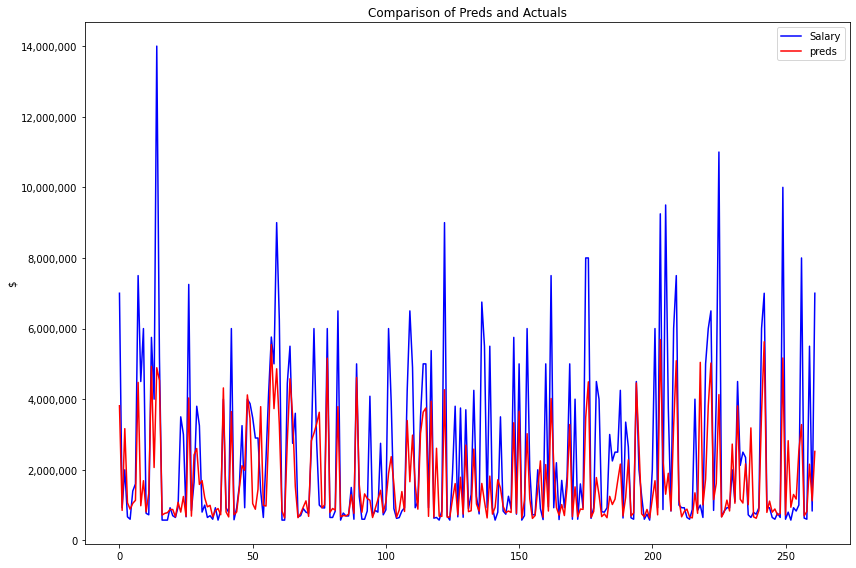

In [59]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
acts.plot(ax=ax, style=['b-','r-']);
plt.title("Comparison of Preds and Actuals");
plt.ylabel('$');
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

In [60]:
mse = mean_squared_error(np.log(acts.Salary), np.log(acts.preds))
mae = mean_absolute_error(np.log(acts.Salary), np.log(acts.preds))

In [61]:
print("Ln Level Mean Squared Error :", mse)
print("Ln Level Mean Absolute Error :", mae)

Ln Level Mean Squared Error : 0.32829220938672277
Ln Level Mean Absolute Error : 0.4263148368980229


In [62]:
fi_df = pd.DataFrame( 100*mod.feature_importance()/mod.feature_importance().max(), 
                      index=full_c.columns, #mod.feature_name(),
                      columns =['importance'])

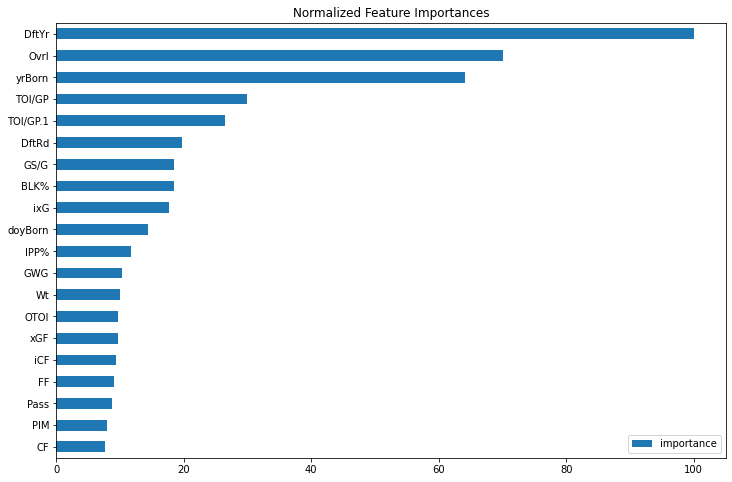

In [63]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
fi_df.sort_values(by='importance',ascending=True).iloc[-20:].plot(kind='barh', color='C0', ax=ax)
plt.title("Normalized Feature Importances");

In [64]:
import statsmodels.api as sma

In [65]:
top10 = fi_df.sort_values(by='importance',ascending=True).iloc[-10:].index
top10

exog = pd.DataFrame(test_c, columns=full_c.columns)[list(top10)].fillna(0)

In [66]:
ols = sma.OLS(exog=exog, endog=acts.Salary)
ols_fit = ols.fit()
print(ols_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.723
Method:                 Least Squares   F-statistic:                              69.44
Date:                Sat, 07 Aug 2021   Prob (F-statistic):                    1.30e-66
Time:                        23:41:30   Log-Likelihood:                         -4143.6
No. Observations:                 262   AIC:                                      8307.
Df Residuals:                     252   BIC:                                      8343.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [1]:
import matplotlib.pyplot as plt

y_pos = np.arange(len(w_results))

weight_variant_names = ["{ 'xgb': 0.33, 'rf': 0.33, 'svm' : 0.34}",
                         "{ 'xgb': 0.9, 'rf': 0.05, 'svm' : 0.05}",
                         "{ 'xgb': 0.8, 'rf': 0.1, 'svm' : 0.1}",
                         "{ 'xgb': 0.5, 'rf': 0.3, 'svm' : 0.2}",
                         "{ 'xgb': 0.3, 'rf': 0.2, 'svm' : 0.5}",
                         "{ 'xgb': 0.3, 'rf': 0.5, 'svm' : 0.2}"]
plt.bar(y_pos, w_results, align='center', alpha=0.5)
plt.xticks(y_pos, weight_variant_names, rotation=90)
plt.ylabel('rmse')
plt.ylim(1300000,1450000)
plt.title('RMSE of different ensemble model weights')
 
plt.show()

NameError: name 'np' is not defined

In [67]:
ols_preds = ols_fit.predict()

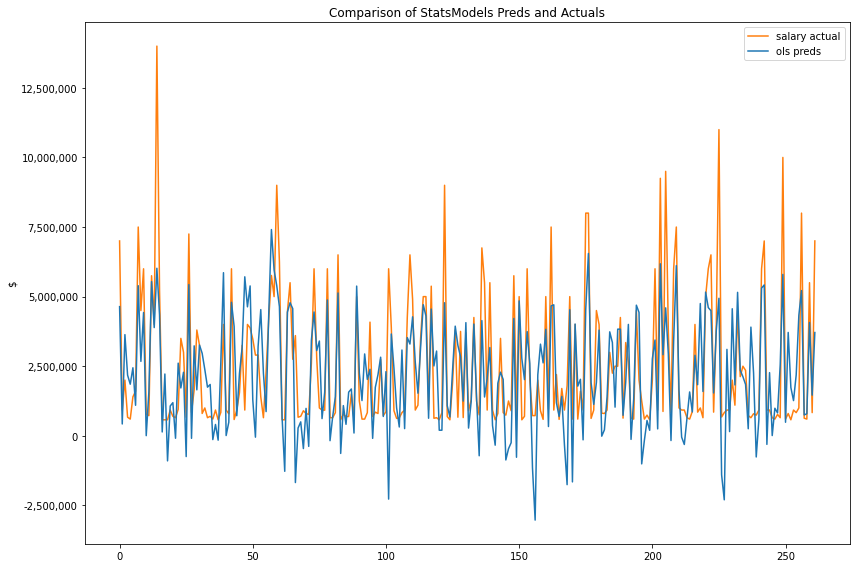

In [68]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
acts.Salary.plot(ax=ax, color='C1');
ax.plot(ols_preds, color='C0');
plt.title("Comparison of StatsModels Preds and Actuals");
plt.ylabel('$');
plt.legend(['salary actual','ols preds']);
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()